In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import utils

In [2]:
np.set_printoptions(threshold=3)

In [3]:
DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
TRAIN_TEST_SPLIT = 3000

In [4]:
WINDOW_SIZE = 60
BATCH_SIZE = 100
SHUFFER_BUFFER_SIZE = 1000

In [5]:
data_path = keras.utils.get_file(os.path.basename(DATA_URL), DATA_URL, cache_dir='./', cache_subdir='')

In [6]:
df_data = pd.read_csv(data_path, index_col=0)
print(f"len(df_data) = {len(df_data)}")
df_data.head()

len(df_data) = 3235


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


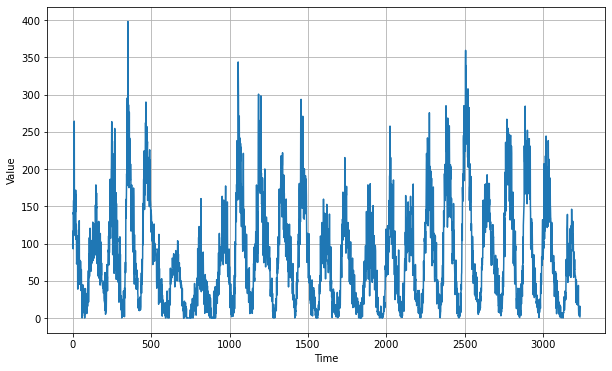

In [7]:
time = df_data.index.to_numpy()
series = df_data['Monthly Mean Total Sunspot Number'].to_numpy()
utils.plot_series(time, series)

In [8]:
t_train = time[:TRAIN_TEST_SPLIT]
x_train = series[:TRAIN_TEST_SPLIT]
t_val = time[TRAIN_TEST_SPLIT:]
x_val = series[TRAIN_TEST_SPLIT:]
print(f"x_train.shape = {x_train.shape}, x_val.shape = {x_val.shape}")

x_train.shape = (3000,), x_val.shape = (235,)


In [9]:
series = tf.expand_dims(x_train, axis=-1)
series

<tf.Tensor: shape=(3000, 1), dtype=float64, numpy=
array([[ 96.7],
       [104.3],
       [116.7],
       ...,
       [ 78.5],
       [ 97.3],
       [119.2]])>

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(series)
for x in dataset.take(1):
    print(x)

tf.Tensor([96.7], shape=(1,), dtype=float64)


In [11]:
windowed_dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)\
    .flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

for x in windowed_dataset.take(3):
    print(f"x shape = {x.shape}, value = \n{x}")

x shape = (61, 1), value = 
[[ 96.7]
 [104.3]
 [116.7]
 ...
 [ 33.3]
 [ 11.2]
 [  0. ]]
x shape = (61, 1), value = 
[[104.3]
 [116.7]
 [ 92.8]
 ...
 [ 11.2]
 [  0. ]
 [  5. ]]
x shape = (61, 1), value = 
[[116.7]
 [ 92.8]
 [141.7]
 ...
 [  0. ]
 [  5. ]
 [  2.8]]


In [12]:
x_y_dataset = windowed_dataset.map(lambda window: (window[:-1], window[-1]))
for x, y in x_y_dataset.take(1):
    print(f"x shape = {x.shape}, value = \n{x}")
    print(f"y shape = {y.shape}, value = \n{y}")

x shape = (60, 1), value = 
[[ 96.7]
 [104.3]
 [116.7]
 ...
 [ 41.7]
 [ 33.3]
 [ 11.2]]
y shape = (1,), value = 
[0.]


In [13]:
cached_dataset = x_y_dataset.cache()
for x, y in cached_dataset.take(1):
    print(f"x shape = {x.shape}, value = \n{x}")
    print(f"y shape = {y.shape}, value = \n{y}")

x shape = (60, 1), value = 
[[ 96.7]
 [104.3]
 [116.7]
 ...
 [ 41.7]
 [ 33.3]
 [ 11.2]]
y shape = (1,), value = 
[0.]


In [14]:
shuffled_dataset = cached_dataset.shuffle(SHUFFER_BUFFER_SIZE)
for x, y in shuffled_dataset.take(1):
    print(f"x shape = {x.shape}, value = \n{x}")
    print(f"y shape = {y.shape}, value = \n{y}")

x shape = (60, 1), value = 
[[36.2]
 [14. ]
 [13.7]
 ...
 [80. ]
 [75.5]
 [80.5]]
y shape = (1,), value = 
[80.]


In [15]:
batched_dataset = shuffled_dataset.batch(BATCH_SIZE).prefetch(1)
for x, y in batched_dataset.take(1):
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")

x.shape = (100, 60, 1)
y.shape = (100, 1)
